### Import data

In [ ]:
include("importData.jl")
include("DDEmodel.jl")
include("plot.jl")

# import data from the path
pop, g2, g1, g2_0, g1_0 = get_data(joinpath("..", "data", "lap.csv"),
                                   joinpath("..", "data", "lap_pop.csv")); # in which:
# pop: population data
# g1, g2: g1 and g2 data
# initial: initial number of cells in g1 and in g2 at time 0


# initial guesses for the parameters
lap = convert(Matrix, param_lap_dde[1:7,2:end]);

### Estimate 

In [ ]:
# i is the number of the column we are using from the data (# of trial)
i = 6

# initial guess
p = [0.02798, 0.025502, 21.3481, 10.2881, 0.0001, 0.0001]

# lower and upper bound set for parameters
low = [0.015, 0.003, 3.0, 7.0, 0.0001, 0.0001]
upp = [0.075, 0.075, 30.0, 100.0, 0.05, 0.05]

# Estimating the parameters for trial i
params = optimIt(p, low, upp, i, g1, g2)

# Plotting the long-term prediction along with the data for trial i
plotIt(params, g1, g2, g1_0, g2_0, pop, i, "Lapatinib")

### Using BlackBoxOptim

In [46]:
using DelayDiffEq, DiffEqParamEstim, Optim, DataFrames, LsqFit, BlackBoxOptim
using Plots
gr()

include("importData.jl")
include("plot.jl")

# import data from the path, in which:
# pop: population data
# g1, g2: g1 and g2 data
# initial: initial number of cells in g1 and in g2 at time 0
pop, g2, g1, g2_0, g1_0 = get_data(joinpath("..", "data", "gem.csv"),
                                   joinpath("..", "data", "gem_pop.csv"))
data = vcat(g1[:, 3]', g2[:, 3]');
times = range(0.0; stop = 95.5, length = 192);

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = get_data(::String, ::String) at importData.jl:29
└ @ Main /home/farnazm/forwardDiff/one_state_model/model/importData.jl:29


In [48]:
# model
function DDEmodel(du, u, h, p, t)
    du[1] = -p[1]*(h(p, t-p[3])[1]) + 2*p[2]*(h(p, t-p[4])[2]) - p[5]*u[1]
    du[2] = p[1]*(h(p, t-p[3])[1]) - p[2]*(h(p, t-p[4])[2]) - p[6]*u[2]
end

# estimate history function
exp_model(t, p) = @. p[1]*exp(t*p[2]) # exponential model

function find_history(g1, g2)

    control_g1 = g1[:, 1] # y1
    control_g2= g2[:, 1] # y2
    p0 = [1.0, 0.5]
    times = range(0.0; stop = 95.5, length = 192) # x
    fit_g1 = curve_fit(exp_model, times, control_g1, p0) 
    fit_g2 = curve_fit(exp_model, times, control_g2, p0) 

    return coef(fit_g1), coef(fit_g2)
end

# define problem generator (optimization in log space)
function prob_generator(prob, p)
    exp_p = exp.(p)
    remake(prob; p = exp_p, constant_lags = [exp_p[3], exp_p[4]])
end

function optimization(g1, g2, g1_0, g2_0, initial_guess, j)
    times = range(0.0; stop = 95.5, length = 192)
    
    # history function
    fit1, fit2 = find_history(g1, g2)
    h(p, t) = [exp_model(t, fit1); exp_model(t, fit2)]

    prob = DDEProblem(DDEmodel, [g1_0[j], g2_0[j]], h, extrema(times), initial_guess;
                      constant_lags = [initial_guess[3], initial_guess[4]])
    alg = MethodOfSteps(AutoTsit5(Rosenbrock23()))
    data = vcat(g1[:, j]', g2[:, j]')

    # objective function
    obj = build_loss_objective(prob, alg, L2Loss(times, data);
                               prob_generator = prob_generator,
                               verbose_opt = false)
    # optimizing
    results_dde = bboptimize(obj; SearchRange=[(-6.0, 0.0), (-6.0, 0.0), (2.0, 6.0), (2.0, 6.0), (-10.0, 0.0), (-10.0, 0.0)],
                                    NumDimensions = 6, TraceMode=:silent)
    # returning estimated parameteres and the objective function
    return exp.(best_candidate(results_dde)), obj
end

function PlotIt(g1_0, g2_0, j, min_p, data)
    new_times = range(0.0; stop=200.0, length=400)
    tspan_new = (0.0, 200.0)
    fit1, fit2 = find_history(g1, g2)
    h(p, t) = [exp_model(t, fit1); exp_model(t, fit2)]
    alg = MethodOfSteps(AutoTsit5(Rosenbrock23()))
    prob_new = DDEProblem(DDEmodel, [g1_0[j], g2_0[j]], h, tspan_new, min_p; constant_lags = [min_p[3], min_p[4]])
    solution = solve(prob_new, alg)
    plot(times, data', show = true, label = ["G1", "G2"], xlabel="time[hours]", ylabel="# of cells", lw=2)
    plot!(new_times, solution(new_times, idxs=1).u, label = "G1 estimated",lw=2)
    plot!(new_times, solution(new_times, idxs=2).u, label = "G2 estimated", lw=2)
end


PlotIt (generic function with 2 methods)

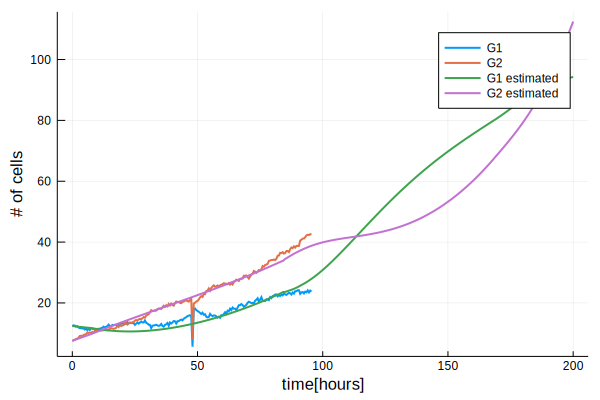

In [49]:
# initial guess
initial_guess = log.([0.02798, 0.025502, 21.3481, 10.2881, 0.0001, 0.0001])
j = 4
min_p, _ = optimization(g1, g2, g1_0, g2_0, initial_guess, j)
data = vcat(g1[:, j]', g2[:, j]');
PlotIt(g1_0, g2_0, j, min_p, data)


### Hill

In [54]:
hill(p, concentration) =  p[2] + ((p[3] - p[2]) / (1 + 10^((concentration - p[1])*p[4])))

function residHill(hillParams, concentrations, g1, g2, g1_0, g2_0)
    """ This functions takes in hill parameters for all the concentrations and calculates
    DDE parameters, passes them to residual function and based off of these, optimizes the model
    and estimates hill parameters. """

    num_concentration = length(concentrations)
    data_size = length(g1[:, 1])
    obj = zeros(num_concentration)

#     EC50  for all of the trials is hillParams[1]
    for ii in 1:num_concentration
        alpha = hill(append!([hillParams[1]], hillParams[2:4]), concentrations[ii])
        beta = hill(append!([hillParams[1]], hillParams[5:7]), concentrations[ii])
        tau1 = hill(append!([hillParams[1]], hillParams[8:10]), concentrations[ii])
        tau2 = hill(append!([hillParams[1]], hillParams[11:13]), concentrations[ii])
        gamma1 = hill(append!([hillParams[1], hillParams[14]], [0, hillParams[15]]), concentrations[ii])
        gamma2 = hill(append!([hillParams[1], hillParams[16]], [0, hillParams[17]]), concentrations[ii])

        pp = [alpha, beta, tau1, tau2, gamma1, gamma2]
        _, obj = optimization(g1, g2, g1_0, g2_0, pp, ii)
    end
    return obj
end

param_gem_dde = CSV.read(joinpath(".", "figures", "Gem", "params_gem_DDE.csv"))
concentrations = permutedims(Vector(param_gem_dde[8,2:end]));
guess = log.([100.0, 0.005, 0.3, 0.02, 0.02, 0.006, 0.02, 25.0, 1.2, 0.02, 20.0, 0.2, 0.02, 0.001, 0.02, 0.01, 0.02])
residHill(guess, concentrations, g1, g2, g1_0, g2_0)

(::DiffEqObjective{getfield(DiffEqParamEstim, Symbol("##39#44")){Nothing,Bool,Int64,typeof(prob_generator),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{,Tuple{}}},DDEProblem{Array{Float64,1},Tuple{Float64,Float64},Array{Float64,1},Tuple{},true,Array{Float64,1},DDEFunction{true,typeof(DDEmodel),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},getfield(Main, Symbol("#h#38")){Array{Float64,1},Array{Float64,1}},Nothing},MethodOfSteps{CompositeAlgorithm{Tuple{Tsit5,Rosenbrock23{0,true,DefaultLinSolve,DataType}},AutoSwitch{Tsit5,Rosenbrock23{0,true,DefaultLinSolve,DataType},Rational{Int64},Float64}},Nothing,Nothing,Nothing,false},L2Loss{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Array{Float64,2},Nothing,Nothing,Nothing},Nothing},getfield(DiffEqParamEstim, Symbol("##43#49"))}) (generic function with 2 methods)

In [ ]:
function optimize_hill(concentrations, guess, low, high, g1, g2)
    obj =residHill(guess, concentrations, g1, g2)
     results_dde = optimize(obj, lower=low,
                           upper=high,
                           log.(guess),
                           Fminbox(Optim.LBFGS()))
    return Optim.minimizer(results_dde)
end

In [ ]:
# lower bound
low = log.([50.0, 0.001, 0.2, 0.01, 0.01, 0.001, 0.01, 20.0, 0.1, 0.01, 19.0, 0.01, 0.01, 0.001, 0.01, 0.001, 0.01])
# upper bound
high = log.([250.0, 0.01, 0.4, 0.04, 0.05, 0.02, 0.04, 35.0, 3.0, 0.04, 23.0, 2.0, 0.4, 0.01, 0.04, 0.04, 0.04])
# initial guess

guess = log.([100.0, 0.005, 0.3, 0.02, 0.02, 0.006, 0.02, 25.0, 1.2, 0.02, 20.0, 0.2, 0.02, 0.001, 0.02, 0.01, 0.02])
# print(guess)
optimize_hill(concentrations, guess, low, high, g1, g2)